<a href="https://colab.research.google.com/github/SHPDH09/Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas matplotlib seaborn scikit-learn tqdm

In [3]:
from google.colab import files
import json
import pandas as pd
from tqdm import tqdm
uploaded = "/content/user_transactions.json"


In [4]:
# Load JSON
with open("user_transactions.json") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')



In [8]:
# Group transactions per wallet
wallets = df['userWallet'].unique()
features = []

for wallet in tqdm(wallets):
    user_df = df[df['userWallet'] == wallet].copy()

    feature_dict = {
        'wallet': wallet,
        'num_deposits': (user_df['action'] == 'deposit').sum(),
        'num_borrows': (user_df['action'] == 'borrow').sum(),
        'num_repays': (user_df['action'] == 'repay').sum(),
        'num_redemptions': (user_df['action'] == 'redeemunderlying').sum(),
        'num_liquidations': (user_df['action'] == 'liquidationcall').sum(),
        'active_days': user_df['timestamp'].dt.date.nunique(),
        'total_deposited': user_df[user_df['action'] == 'deposit']['actionData'].apply(lambda x: float(x.get('amount', 0))).sum(),
        'total_borrowed': user_df[user_df['action'] == 'borrow']['actionData'].apply(lambda x: float(x.get('amount', 0))).sum(),
        'total_repaid': user_df[user_df['action'] == 'repay']['actionData'].apply(lambda x: float(x.get('amount', 0))).sum(),
    }
    features.append(feature_dict)

features_df = pd.DataFrame(features)

100%|██████████| 3497/3497 [00:55<00:00, 62.54it/s]


In [9]:
def score_wallet(row):
    score = 0
    score += min(row['total_deposited'] / 1000, 100) * 1.5
    score += min(row['total_repaid'] / 1000, 100) * 1.5
    score -= row['num_liquidations'] * 50
    score += row['num_deposits'] * 2
    score += row['num_repays'] * 2
    score -= row['num_borrows'] * 1
    return max(min(score, 1000), 0)



In [13]:
# Calculate additional features
features_df['repay_ratio'] = features_df.apply(
    lambda row: row['total_repaid'] / row['total_borrowed'] if row['total_borrowed'] > 0 else 0, axis=1
)

features_df['liquidation_rate'] = features_df.apply(
    lambda row: row['num_liquidations'] / (row['num_borrows'] + row['num_deposits']) if (row['num_borrows'] + row['num_deposits']) > 0 else 0, axis=1
)

features_df['deposit_borrow_ratio'] = features_df.apply(
    lambda row: row['total_deposited'] / row['total_borrowed'] if row['total_borrowed'] > 0 else 0, axis=1
)

features_df['avg_txn_amount'] = features_df.apply(
    lambda row: (row['total_deposited'] + row['total_borrowed'] + row['total_repaid']) / (row['num_deposits'] + row['num_borrows'] + row['num_repays']) if (row['num_deposits'] + row['num_borrows'] + row['num_repays']) > 0 else 0, axis=1
)

#Normalize Features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = ['total_deposited', 'total_borrowed', 'total_repaid', 'repay_ratio',
                'liquidation_rate', 'deposit_borrow_ratio', 'avg_txn_amount']

features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

In [14]:
#Detect Suspicious Wallets
def is_suspicious(row):
    return (
        row['repay_ratio'] < 0.2 and
        row['avg_txn_amount'] < 5 and
        row['num_borrows'] > 10
    )

features_df['suspicious_flag'] = features_df.apply(is_suspicious, axis=1)


In [17]:
def credit_level(score):
    if score < 400:
        return 'Low'
    elif score < 700:
        return 'Mid'
    else:
        return 'High'

features_df['credit_score'] = features_df.apply(score_wallet, axis=1)
features_df['credit_level'] = features_df['credit_score'].apply(credit_level)
features_df[['wallet', 'credit_score', 'credit_level','suspicious_flag']].head()

,wallet,credit_score,credit_level,suspicious_flag
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2.000000,Low,False
1,0x000000000051d07a4fb3bd10121a343d85818da6,2.000000,Low,False
2,0x000000000096026fb41fc39f9875d164bd82e2dc,4.000000,Low,False
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000,Low,False
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,493.000003,Mid,True


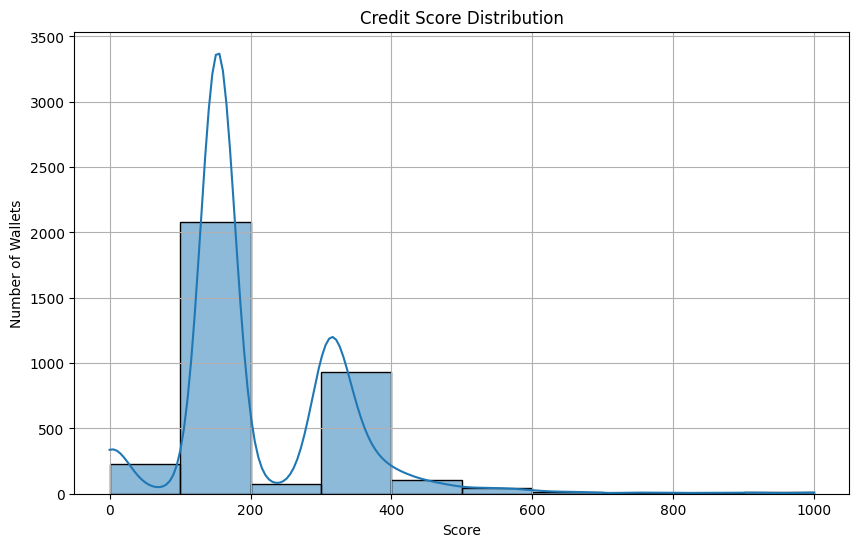

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(features_df['credit_score'], bins=10, kde=True)
plt.title('Credit Score Distribution')
plt.xlabel('Score')
plt.ylabel('Number of Wallets')
plt.grid(True)
plt.show()


In [18]:
features_df[['wallet', 'credit_score','credit_level','suspicious_flag']].to_csv('score_output.csv', index=False)
files.download('score_output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>